# Addressing Extreme Rare Cases with SmoteR for Regression

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import visualization
import matplotlib.pyplot as plt

# import machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer

## Load the Data

In [2]:
# load data
fires = pd.read_csv('../input/forest-fires-data-set/forestfires.csv')
fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


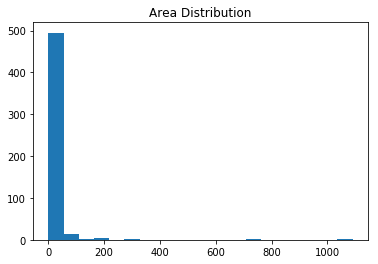

In [3]:
plt.hist(fires.area, bins=20)
plt.title('Area Distribution')
plt.show()

Long-tailed distribution with small number of samples for high area values.

In [4]:
# simple regression model
fires = fires.drop(columns=['X', 'Y'])

months_to_remove = ['nov','jan','may']
fires = fires.drop(fires[fires.month.isin(months_to_remove)].index ,axis=0)

#fires['area'] = fires[fires['area'] < 100]

fires['temp_bins'] = pd.cut(fires.temp, bins=[0, 15, 20, 25, 40], include_lowest=True, 
                                 labels=['0-15', '15-20', '20-25', '>25'])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(fires.values, fires.temp_bins.values):
    st_train_set = fires.iloc[train_index]
    st_test_set = fires.iloc[test_index]

## Regression

In [5]:
X_train = st_train_set.drop(columns=['area', 'temp_bins'])
X_train = pd.get_dummies(X_train)
y_train = st_train_set[['area']]

X_test = st_test_set.drop(columns=['area', 'temp_bins'])
X_test = pd.get_dummies(X_test)
y_test = st_test_set[['area']]

model = RandomForestRegressor(max_depth=2, min_samples_split=2, min_samples_leaf=1, random_state=0, n_estimators=100)
model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)

# print out the prediction scores
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print('R-squared: {}'.format(r2_score(y_test, y_pred)))

RMSE: 80.90378771420649
MAE: 22.520703240785696
R-squared: -0.005152996977448865


Text(0.5, 1.0, 'Predicted vs True values')

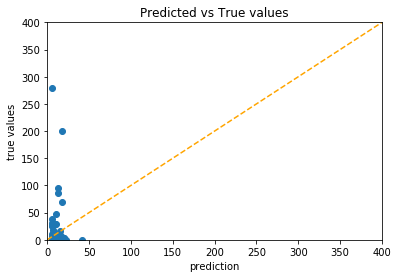

In [6]:
plt.scatter(y_pred, y_test)
plt.plot(np.linspace(0,400,400), np.linspace(0,400,400), c = 'orange', linestyle='--')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.xlim(0,400)
plt.ylim(0,400)
plt.title('Predicted vs True values')

We see that the model performs very bad. Ideally the dots should be near the line.

## Implement SmoteR

### Create Relevance Function

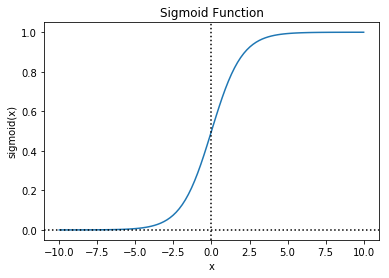

In [7]:
# define sigmoid function
# https://en.wikipedia.org/wiki/Sigmoid_function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# plot sigmoid function
plt.plot(np.linspace(-10, 10, 100), sigmoid(np.linspace(-10, 10, 100)))
plt.title('Sigmoid Function')
plt.xlabel('x')
plt.axhline(y=0, c='black', linestyle=':')
plt.axvline(x=0, c='black', linestyle=':')
plt.ylabel('sigmoid(x)')
plt.show()

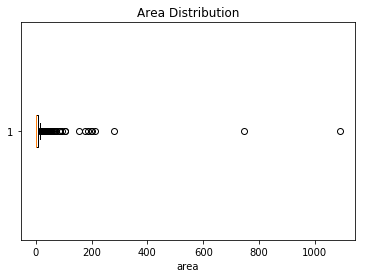

In [8]:
# plot the boxplot of area distribution
plt.boxplot(fires.area, vert=False)
plt.title('Area Distribution')
plt.xlabel('area')
plt.show()

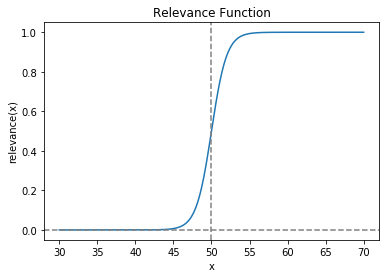

In [9]:
# implement relevance function
# see paper: https://www.researchgate.net/publication/220699419_Utility-Based_Regression
def relevance(x):
    x = np.array(x)
    return sigmoid(x - 50)

# plot relevance function
plt.plot(np.linspace(30, 70, 1000), relevance(np.linspace(30, 70, 1000)))
plt.title('Relevance Function')
plt.xlabel('x')
plt.axhline(y=0, c='gray', linestyle='--')
plt.axvline(x=50, c='gray', linestyle='--')
plt.ylabel('relevance(x)')
plt.show()

### Implement SmoteR

In [10]:
# implement SMOTER
# see paper: https://core.ac.uk/download/pdf/29202178.pdf

def get_synth_cases(D, target, o=200, k=3, categorical_col = []):
    '''
    Function to generate the new cases.
    INPUT:
        D - pd.DataFrame with the initial data
        target - string name of the target column in the dataset
        o - oversampling rate
        k - number of nearest neighbors to use for the generation
        categorical_col - list of categorical column names
    OUTPUT:
        new_cases - pd.DataFrame containing new generated cases
    '''
    new_cases = pd.DataFrame(columns = D.columns) # initialize the list of new cases 
    ng = o // 100 # the number of new cases to generate
    for index, case in D.iterrows():
        # find k nearest neighbors of the case
        knn = KNeighborsRegressor(n_neighbors = k+1) # k+1 because the case is the nearest neighbor to itself
        knn.fit(D.drop(columns = [target]).values, D[[target]])
        neighbors = knn.kneighbors(case.drop(labels = [target]).values.reshape(1, -1), return_distance=False).reshape(-1)
        neighbors = np.delete(neighbors, np.where(neighbors == index))
        for i in range(0, ng):
            # randomly choose one of the neighbors
            x = D.iloc[neighbors[np.random.randint(k)]]
            attr = {}          
            for a in D.columns:
                # skip target column
                if a == target:
                    continue;
                if a in categorical_col:
                    # if categorical then choose randomly one of values
                    if np.random.randint(2) == 0:
                        attr[a] = case[a]
                    else:
                        attr[a] = x[a]
                else:
                    # if continious column
                    diff = case[a] - x[a]
                    attr[a] = case[a] + np.random.randint(2) * diff
            # decide the target column
            new = np.array(list(attr.values()))
            d1 = cosine_similarity(new.reshape(1, -1), case.drop(labels = [target]).values.reshape(1, -1))[0][0]
            d2 = cosine_similarity(new.reshape(1, -1), x.drop(labels = [target]).values.reshape(1, -1))[0][0]
            attr[target] = (d2 * case[target] + d1 * x[target]) / (d1 + d2)
            
            # append the result
            new_cases = new_cases.append(attr,ignore_index = True)
                    
    return new_cases

def SmoteR(D, target, th = 0.999, o = 200, u = 100, k = 3, categorical_col = []):
    '''
    The implementation of SmoteR algorithm:
    https://core.ac.uk/download/pdf/29202178.pdf
    INPUT:
        D - pd.DataFrame - the initial dataset
        target - the name of the target column in the dataset
        th - relevance threshold
        o - oversampling rate
        u - undersampling rate
        k - the number of nearest neighbors
    OUTPUT:
        new_D - the resulting new dataset
    '''
    # median of the target variable
    y_bar = D[target].median()
    
    # find rare cases where target less than median
    rareL = D[(relevance(D[target]) > th) & (D[target] > y_bar)]  
    # generate rare cases for rareL
    new_casesL = get_synth_cases(rareL, target, o, k , categorical_col)
    
    # find rare cases where target greater than median
    rareH = D[(relevance(D[target]) > th) & (D[target] < y_bar)]
    # generate rare cases for rareH
    new_casesH = get_synth_cases(rareH, target, o, k , categorical_col)
    
    new_cases = pd.concat([new_casesL, new_casesH], axis=0)
    
    # undersample norm cases
    norm_cases = D[relevance(D[target]) <= th]
    # get the number of norm cases
    nr_norm = int(len(norm_cases) * u / 100)
    
    norm_cases = norm_cases.sample(min(len(D[relevance(D[target]) <= th]), nr_norm))
    
    # get the resulting dataset
    new_D = pd.concat([new_cases, norm_cases], axis=0)
    
    return new_D

## Add SmoteR

In [11]:
# construct the initial dataset for SmoteR
cols = X_train.columns.tolist()
cols.append('area')
D = pd.DataFrame(np.concatenate([X_train, y_train], axis=1), columns = cols)

In [21]:
# apply SmoteR to get the new dataset
np.random.seed(43)
Xs = SmoteR(D, target='area', th = 0.999, o = 300, u = 100, k = 3, categorical_col = ['month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu',
       'day_tue', 'day_wed'])

X_train = Xs.drop(columns=['area'])
y_train = Xs[['area']]


# model and check the results
model = RandomForestRegressor(max_depth=2, min_samples_split=2, min_samples_leaf=1, random_state=0, n_estimators=100)

model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)

# print out the prediction scores
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print('R-squared: {}'.format(r2_score(y_test, y_pred)))

RMSE: 80.3512418929407
MAE: 30.98104722369985
R-squared: 0.00852983615799896


Text(0.5, 1.0, 'Predicted vs True values')

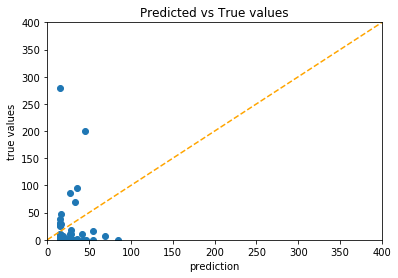

In [22]:
# plot the results
plt.scatter(y_pred, y_test)
plt.plot(np.linspace(0,400,400), np.linspace(0,400,400), c = 'orange', linestyle='--')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.xlim(0,400)
plt.ylim(0,400)
plt.title('Predicted vs True values')

## Add SMOGN

In [14]:
import bisect as bs
import numpy.random as rd

## calculate parameters for phi relevance function
def phi_ctrl_pts(
    
    ## arguments / inputs
    y,                    ## response variable y
    method = "auto",      ## relevance method ("auto" or "manual")
    xtrm_type = "both",   ## distribution focus ("high", "low", "both")
    coef = 1.5,           ## coefficient for box plot
    ctrl_pts = None       ## input for "manual" rel method
    
    ):
    
    """ 
    generates the parameters required for the 'phi()' function, specifies the 
    regions of interest or 'relevance' in the response variable y, the notion 
    of relevance can be associated with rarity
    
    controls how the relevance parameters are calculated by selecting between 
    two methods, either "auto" or "manual"
    
    the "auto" method calls the function 'phi_extremes()' and calculates the 
    relevance parameters by the values beyond the interquartile range
    
    the "manual" method calls the function 'phi_range()' and determines the 
    relevance parameters by user specification (the use of a domain expert 
    is recommended for utilizing this method)
    
    returns a dictionary containing 3 items "method", "num_pts", "ctrl_pts": 
    1) the "method" item contains a chartacter string simply indicating the 
    method used calculate the relevance parameters (control points) either 
    "auto" or "manual"
    
    2) the "num_pts" item contains a positive integer simply indicating the 
    number of relevance parameters returned, typically 3
    
    3) the "ctrl_pts" item contains an array indicating the regions of 
    interest in the response variable y and their corresponding relevance 
    values mapped to either 0 or 1, expressed as [y, 0, 1]
    
    ref:
    
    Branco, P., Ribeiro, R., Torgo, L. (2017).
    Package 'UBL'. The Comprehensive R Archive Network (CRAN).
    https://cran.r-project.org/web/packages/UBL/UBL.pdf.
    
    Ribeiro, R. (2011). Utility-Based Regression.
    (PhD Dissertation, Dept. Computer Science, 
    Faculty of Sciences, University of Porto).
    """
    
    ## quality control check for response variable 'y'
    if any(y == None) or isinstance(y, (int, float, complex)):
        print("response variable 'y' must be specified and numeric")
    
    ## quality control check for user specified method
    if method in ["auto", "manual"] == False:
        print("method must be either: 'auto' or 'manual'")
    
    ## conduct 'extremes' method (default)
    if method == "auto":
        phi_params = phi_extremes(y, xtrm_type, coef, ctrl_pts)
    
    ## conduct 'range' method
    if method == "manual":
        phi_params = phi_range(y, xtrm_type, coef, ctrl_pts)
    
    ## return phi relevance parameters dictionary
    return phi_params

## calculates phi parameters for statistically extreme values
def phi_extremes(y, xtrm_type, coef, ctrl_pts):
  
    """ 
    assigns relevance to the most extreme values in the distribution of response 
    variable y according to the box plot stats generated from 'box_plot_stat()'
    """
    
    ## create 'ctrl_pts' variable
    ctrl_pts = []
    
    ## calculates statistically extreme values by
    ## box plot stats in the response variable y
    ## (see function 'boxplot_stats()' for details)
    bx_plt_st = box_plot_stats(y, coef)
    
    ## calculate range of the response variable y
    rng = [y.min(), y.max()]
    
    ## adjust low
    if xtrm_type in ["both", "low"] and any(bx_plt_st["xtrms"]
    < bx_plt_st["stats"][0]):
        ctrl_pts.extend([bx_plt_st["stats"][0], 1, 0])
   
    ## min
    else:
        ctrl_pts.extend([rng[0], 0, 0])
      
    ## median
    if bx_plt_st["stats"][2] != rng[0]:
        ctrl_pts.extend([bx_plt_st["stats"][2], 0, 0])
    
    ## adjust high
    if xtrm_type in ["both", "high"] and any(bx_plt_st["xtrms"]
    > bx_plt_st["stats"][4]):
        ctrl_pts.extend([bx_plt_st["stats"][4], 1, 0])
    
    ## max
    else:
        if bx_plt_st["stats"][2] != rng[1]:
            ctrl_pts.extend([rng[1], 0, 0])
    
    ## store phi relevance parameter dictionary
    phi_params = {}
    phi_params["method"] = "extremes"
    phi_params["num_pts"] = round(len(ctrl_pts) / 3)
    phi_params["ctrl_pts"] = ctrl_pts
    
    ## return dictionary
    return phi_params

## calculates phi parameters for user specified range
def phi_range(y, xtrm_type, coef, ctrl_pts):
    
    """
    assigns relevance to values in the response variable y according to user 
    specification, when specifying relevant regions use matrix format [x, y, m]
    
    x is an array of relevant values in the response variable y, y is an array 
    of values mapped to 1 or 0, and m is typically an array of zeros
    
    m is the phi derivative adjusted afterward by the phi relevance function to 
    interpolate a smooth and continous monotonically increasing function
    
    example:
    [x,  y, m],
    [15, 1, 0],
    [30, 0, 0],
    [55, 1, 0]
    """
    
    ## load dependencies
    # import numpy as np
    
    ## convert 'ctrl_pts' to numpy 2d array (matrix)
    ctrl_pts = np.array(ctrl_pts)
                   
    ## quality control checks for user specified phi relevance values
    if np.isnan(ctrl_pts).any() or np.size(ctrl_pts, axis = 1) > 3 or np.size(
        ctrl_pts, axis = 1) < 2 or not isinstance(ctrl_pts, (np.ndarray)):
        print("ctrl_pts must be given as a matrix in the form: [x, y, m]" 
              "or [x, y]")
    
    if (ctrl_pts[1: ,[1, ]] > 1).any() or (ctrl_pts[1: ,[1, ]] < 0).any():
        print("phi relevance function only maps values: [0, 1]")
          
    ## store number of control points 
    else:
        num_pts = np.size(ctrl_pts, axis = 0)
        dx = ctrl_pts[1:,[0,]] - ctrl_pts[0:-1,[0,]]
    
    ## quality control check for dx
    if np.isnan(dx).any() or dx.any() == 0:
        print("x must strictly increase (not na)")
    
    ## sort control points from lowest to highest
    else:
        ctrl_pts = ctrl_pts[np.argsort(ctrl_pts[:,0])]
    
    ## calculate for two column user specified control points [x, y]
    if np.size(ctrl_pts, axis = 1) == 2:
        
        ## monotone hermite spline method by fritsch & carlson (monoH.FC)
        dx = ctrl_pts[1:,[0,]] - ctrl_pts[0:-1,[0,]]
        dy = ctrl_pts[1:,[1,]] - ctrl_pts[0:-1,[1,]]
        sx = dy / dx
        
        ## calculate constant extrapolation
        m = np.divide(sx[1:] + sx[0:-1], 2)
        m = np.array(ex).ravel().tolist()
        m.insert(0, 0)
        m.insert(len(ex), 0)
        
        ## add calculated column 'm' to user specified control points 
        ## from [x, y] to [x, y, m] and store in 'ctrl_pts'
        ctrl_pts = np.insert(ctrl_pts, 2, m, axis = 1)
    
    ## store phi relevance parameter dictionary
    phi_params = {}
    phi_params["method"] = "range"
    phi_params["num_pts"] = np.size(ctrl_pts, axis = 0)
    phi_params["ctrl_pts"] = np.array(ctrl_pts).ravel().tolist()
    
    ## return dictionary
    return phi_params

## calculate parameters for phi relevance function
def phi_ctrl_pts(
    
    ## arguments / inputs
    y,                    ## response variable y
    method = "auto",      ## relevance method ("auto" or "manual")
    xtrm_type = "both",   ## distribution focus ("high", "low", "both")
    coef = 1.5,           ## coefficient for box plot
    ctrl_pts = None       ## input for "manual" rel method
    
    ):
    
    """ 
    generates the parameters required for the 'phi()' function, specifies the 
    regions of interest or 'relevance' in the response variable y, the notion 
    of relevance can be associated with rarity
    
    controls how the relevance parameters are calculated by selecting between 
    two methods, either "auto" or "manual"
    
    the "auto" method calls the function 'phi_extremes()' and calculates the 
    relevance parameters by the values beyond the interquartile range
    
    the "manual" method calls the function 'phi_range()' and determines the 
    relevance parameters by user specification (the use of a domain expert 
    is recommended for utilizing this method)
    
    returns a dictionary containing 3 items "method", "num_pts", "ctrl_pts": 
    1) the "method" item contains a chartacter string simply indicating the 
    method used calculate the relevance parameters (control points) either 
    "auto" or "manual"
    
    2) the "num_pts" item contains a positive integer simply indicating the 
    number of relevance parameters returned, typically 3
    
    3) the "ctrl_pts" item contains an array indicating the regions of 
    interest in the response variable y and their corresponding relevance 
    values mapped to either 0 or 1, expressed as [y, 0, 1]
    
    ref:
    
    Branco, P., Ribeiro, R., Torgo, L. (2017).
    Package 'UBL'. The Comprehensive R Archive Network (CRAN).
    https://cran.r-project.org/web/packages/UBL/UBL.pdf.
    
    Ribeiro, R. (2011). Utility-Based Regression.
    (PhD Dissertation, Dept. Computer Science, 
    Faculty of Sciences, University of Porto).
    """
    
    ## quality control check for response variable 'y'
    if any(y == None) or isinstance(y, (int, float, complex)):
        print("response variable 'y' must be specified and numeric")
    
    ## quality control check for user specified method
    if method in ["auto", "manual"] == False:
        print("method must be either: 'auto' or 'manual'")
    
    ## conduct 'extremes' method (default)
    if method == "auto":
        phi_params = phi_extremes(y, xtrm_type, coef, ctrl_pts)
    
    ## conduct 'range' method
    if method == "manual":
        phi_params = phi_range(y, xtrm_type, coef, ctrl_pts)
    
    ## return phi relevance parameters dictionary
    return phi_params

## calculates phi parameters for statistically extreme values
def phi_extremes(y, xtrm_type, coef, ctrl_pts):
  
    """ 
    assigns relevance to the most extreme values in the distribution of response 
    variable y according to the box plot stats generated from 'box_plot_stat()'
    """
    
    ## create 'ctrl_pts' variable
    ctrl_pts = []
    
    ## calculates statistically extreme values by
    ## box plot stats in the response variable y
    ## (see function 'boxplot_stats()' for details)
    bx_plt_st = box_plot_stats(y, coef)
    
    ## calculate range of the response variable y
    rng = [y.min(), y.max()]
    
    ## adjust low
    if xtrm_type in ["both", "low"] and any(bx_plt_st["xtrms"]
    < bx_plt_st["stats"][0]):
        ctrl_pts.extend([bx_plt_st["stats"][0], 1, 0])
   
    ## min
    else:
        ctrl_pts.extend([rng[0], 0, 0])
      
    ## median
    if bx_plt_st["stats"][2] != rng[0]:
        ctrl_pts.extend([bx_plt_st["stats"][2], 0, 0])
    
    ## adjust high
    if xtrm_type in ["both", "high"] and any(bx_plt_st["xtrms"]
    > bx_plt_st["stats"][4]):
        ctrl_pts.extend([bx_plt_st["stats"][4], 1, 0])
    
    ## max
    else:
        if bx_plt_st["stats"][2] != rng[1]:
            ctrl_pts.extend([rng[1], 0, 0])
    
    ## store phi relevance parameter dictionary
    phi_params = {}
    phi_params["method"] = "extremes"
    phi_params["num_pts"] = round(len(ctrl_pts) / 3)
    phi_params["ctrl_pts"] = ctrl_pts
    
    ## return dictionary
    return phi_params

## calculates phi parameters for user specified range
def phi_range(y, xtrm_type, coef, ctrl_pts):
    
    """
    assigns relevance to values in the response variable y according to user 
    specification, when specifying relevant regions use matrix format [x, y, m]
    
    x is an array of relevant values in the response variable y, y is an array 
    of values mapped to 1 or 0, and m is typically an array of zeros
    
    m is the phi derivative adjusted afterward by the phi relevance function to 
    interpolate a smooth and continous monotonically increasing function
    
    example:
    [x,  y, m],
    [15, 1, 0],
    [30, 0, 0],
    [55, 1, 0]
    """
    
    ## load dependencies
    # import numpy as np
    
    ## convert 'ctrl_pts' to numpy 2d array (matrix)
    ctrl_pts = np.array(ctrl_pts)
                   
    ## quality control checks for user specified phi relevance values
    if np.isnan(ctrl_pts).any() or np.size(ctrl_pts, axis = 1) > 3 or np.size(
        ctrl_pts, axis = 1) < 2 or not isinstance(ctrl_pts, (np.ndarray)):
        print("ctrl_pts must be given as a matrix in the form: [x, y, m]" 
              "or [x, y]")
    
    if (ctrl_pts[1: ,[1, ]] > 1).any() or (ctrl_pts[1: ,[1, ]] < 0).any():
        print("phi relevance function only maps values: [0, 1]")
          
    ## store number of control points 
    else:
        num_pts = np.size(ctrl_pts, axis = 0)
        dx = ctrl_pts[1:,[0,]] - ctrl_pts[0:-1,[0,]]
    
    ## quality control check for dx
    if np.isnan(dx).any() or dx.any() == 0:
        print("x must strictly increase (not na)")
    
    ## sort control points from lowest to highest
    else:
        ctrl_pts = ctrl_pts[np.argsort(ctrl_pts[:,0])]
    
    ## calculate for two column user specified control points [x, y]
    if np.size(ctrl_pts, axis = 1) == 2:
        
        ## monotone hermite spline method by fritsch & carlson (monoH.FC)
        dx = ctrl_pts[1:,[0,]] - ctrl_pts[0:-1,[0,]]
        dy = ctrl_pts[1:,[1,]] - ctrl_pts[0:-1,[1,]]
        sx = dy / dx
        
        ## calculate constant extrapolation
        m = np.divide(sx[1:] + sx[0:-1], 2)
        m = np.array(ex).ravel().tolist()
        m.insert(0, 0)
        m.insert(len(ex), 0)
        
        ## add calculated column 'm' to user specified control points 
        ## from [x, y] to [x, y, m] and store in 'ctrl_pts'
        ctrl_pts = np.insert(ctrl_pts, 2, m, axis = 1)
    
    ## store phi relevance parameter dictionary
    phi_params = {}
    phi_params["method"] = "range"
    phi_params["num_pts"] = np.size(ctrl_pts, axis = 0)
    phi_params["ctrl_pts"] = np.array(ctrl_pts).ravel().tolist()
    
    ## return dictionary
    return phi_params

## calculate box plot statistics
def box_plot_stats(
    
    ## arguments / inputs
    x,          ## input array of values 
    coef = 1.5  ## positive real number
                ## (determines how far the whiskers extend from the iqr)
    ):          
    
    """ 
    calculates box plot five-number summary: the lower whisker extreme, the 
    lower ‘hinge’ (observed value), the median, the upper ‘hinge’, and upper 
    whisker extreme (observed value)
    
    returns a results dictionary containing 2 items: "stats" and "xtrms"
    1) the "stats" item contains the box plot five-number summary as an array
    2) the "xtrms" item contains values which lie beyond the box plot extremes
    
    functions much the same as R's 'boxplot.stats()' function for which this
    Python implementation was predicated
    
    ref:
    
    The R Project for Statistical Computing. (2019). Box Plot Statistics. 
    http://finzi.psych.upenn.edu/R/library/grDevices/html/boxplot.stats.html.
    
    Tukey, J. W. (1977). Exploratory Data Analysis. Section 2C.
    McGill, R., Tukey, J.W. and Larsen, W.A. (1978). Variations of Box Plots. 
    The American Statistician, 32:12-16. http://dx.doi.org/10.2307/2683468.
    Velleman, P.F. and Hoaglin, D.C. (1981). Applications, Basics and 
    Computing of Exploratory Data Analysis. Duxbury Press.
    Emerson, J.D. and Strenio, J. (1983). Boxplots and Batch Comparison. 
    Chapter 3 of Understanding Robust and Exploratory Data Analysis, 
    eds. D.C. Hoaglin, F. Mosteller and J.W. Tukey. Wiley.
    Chambers, J.M., Cleveland, W.S., Kleiner, B. and Tukey, P.A. (1983). 
    Graphical Methods for Data Analysis. Wadsworth & Brooks/Cole.
    """
    
    ## load dependency
    # import numpy as np
    
    ## convert input to numpy array
    x = np.array(x)
    
    ## determine median, lower ‘hinge’, upper ‘hinge’
    median = np.quantile(a = x, q = 0.50, interpolation = "midpoint")
    first_quart = np.quantile(a = x, q = 0.25, interpolation = "midpoint")
    third_quart = np.quantile(a = x, q = 0.75, interpolation = "midpoint")
    
    ## calculate inter quartile range
    intr_quart_rng = third_quart - first_quart
    
    ## calculate extreme of the lower whisker (observed, not interpolated)
    lower = first_quart - (coef * intr_quart_rng)
    lower_whisk = np.compress(x >= lower, x)
    lower_whisk_obs = np.min(lower_whisk)
    
    ## calculate extreme of the upper whisker (observed, not interpolated)
    upper = third_quart + (coef * intr_quart_rng)
    upper_whisk = np.compress(x <= upper, x)
    upper_whisk_obs = np.max(upper_whisk)
    
    ## store box plot results dictionary
    boxplot_stats = {}
    boxplot_stats["stats"] = np.array([lower_whisk_obs, 
                                       first_quart, 
                                       median, 
                                       third_quart, 
                                       upper_whisk_obs])
   
    ## store observations beyond the box plot extremes
    boxplot_stats["xtrms"] = np.array(x[(x < lower_whisk_obs) | 
                                        (x > upper_whisk_obs)])
    
    ## return dictionary        
    return boxplot_stats

## calculate the phi relevance function
def phi(
    
    ## arguments / inputs
    y,        ## reponse variable y
    ctrl_pts  ## params from the 'ctrl_pts()' function
    
    ):
    
    """
    generates a monotonic piecewise cubic spline from a sorted list (ascending)
    of the response variable y in order to determine which observations exceed 
    a given threshold ('rel_thres' argument in the main 'smogn()' function)
    
    returns an array of length n (number of observations in the training set) of 
    the phi relevance values corresponding to each observation in y to determine
    whether or not an given observation in y is considered 'normal' or 'rare'
    
    the 'normal' observations get placed into a majority class subset or 'bin' 
    (normal bin) and are under-sampled, while the 'rare' observations get placed 
    into seperate minority class subset (rare bin) where they are over-sampled
    
    the original implementation was as an R foreign function call to C and later 
    adapted to Fortran 90, but was implemented here in Python for the purposes
    of consistency and maintainability
    
    ref:
    
    Branco, P., Ribeiro, R., Torgo, L. (2017). 
    Package 'UBL'. The Comprehensive R Archive Network (CRAN).
    https://cran.r-project.org/web/packages/UBL/UBL.pdf.
    
    Fritsch, F., Carlson, R. (1980).
    Monotone Piecewise Cubic Interpolation.
    SIAM Journal on Numerical Analysis, 17(2):238-246.
    https://doi.org/10.1137/0717021.
    
    Ribeiro, R. (2011). Utility-Based Regression.
    (PhD Dissertation, Dept. Computer Science, 
    Faculty of Sciences, University of Porto).
    """
    
    ## assign variables
    y = y                                ## reponse variable y
    n = len(y)                           ## number of points in y
    num_pts = ctrl_pts["num_pts"]    ## number of control points
    ctrl_pts = ctrl_pts["ctrl_pts"]  ## control points
    
    ## reindex y
    y = y.reset_index(drop = True)
    
    ## initialize phi relevance function
    y_phi = phi_init(y, n, num_pts, ctrl_pts)
    
    ## return phi values
    return y_phi

## pre-process control points and calculate phi values
def phi_init(y, n, num_pts, ctrl_pts):
    
    ## construct control point arrays
    x = []
    y_rel = []
    m = []
    
    for i in range(num_pts):
        x.append(ctrl_pts[3 * i])
        y_rel.append(ctrl_pts[3 * i + 1])
        m.append(ctrl_pts[3 * i + 2])
    
    ## calculate auxilary coefficients for 'pchip_slope_mono_fc()'
    h = []
    delta = []
    
    for i in range(num_pts - 1):
        h.append(x[i + 1] - x[i])
        delta.append((y_rel[i + 1] - y_rel[i]) / h[i])
    
    ## conduct monotone piecewise cubic interpolation
    m_adj = pchip_slope_mono_fc(m, delta, num_pts)
    
    ## assign variables for 'pchip_val()'
    a = y_rel
    b = m_adj
    
    ## calculate auxilary coefficients for 'pchip_val()'
    c = []
    d = []
    
    for i in range(num_pts - 1):
        c.append((3 * delta[i] - 2 * m_adj[i] - m_adj[i + 1]) / h[i])
        d.append((m_adj[i] - 2 * delta[i] + m_adj[i + 1]) / (h[i] * h[i]))
    
    ## calculate phi values
    y_phi = [None] * n
    
    for i in range(n):
        y_phi[i] = pchip_val(y[i], x, a, b, c, d, num_pts)
    
    ## return phi values to the higher function 'phi()'
    return y_phi

## calculate slopes for shape preserving hermite cubic polynomials
def pchip_slope_mono_fc(m, delta, num_pts):
    
    for k in range(num_pts - 1):
        sk = delta[k]
        k1 = k + 1
        
        if abs(sk) == 0:
            m[k] = m[k1] = 0
        
        else:
            alpha = m[k] / sk
            beta = m[k1] / sk
            
            if abs(m[k]) != 0 and alpha < 0:
                m[k] = -m[k]
                alpha = m[k] / sk
            
            if abs(m[k1]) != 0 and beta < 0:
                m[k1] = -m[k1]
                beta = m[k1] / sk
            
            ## pre-process for monotoncity check
            m_2ab3 = 2 * alpha + beta - 3
            m_a2b3 = alpha + 2 * beta - 3
            
            ## check for monotoncity
            if m_2ab3 > 0 and m_a2b3 > 0 and alpha * (
                m_2ab3 + m_a2b3) < (m_2ab3 * m_2ab3):
                
                ## fix slopes if outside of monotoncity
                taus = 3 * sk / sqrt(alpha * alpha + beta * beta)
                m[k] = taus * alpha
                m[k1] = taus * beta
    
    ## return adjusted slopes m
    return m

## calculate phi values based on monotone piecewise cubic interpolation
def pchip_val(y, x, a, b, c, d, num_pts):
    
    ## load dependency
    # import bisect as bs
    
    ## find interval that contains or is nearest to y
    i = bs.bisect(
        
        a = x,  ## array of relevance values
        x = y   ## single observation in y
        ) - 1   ## minus 1 to match index position
    
    ## calculate phi values
    if i == num_pts - 1:
        y_val = a[i] + b[i] * (y - x[i])
    
    elif i < 0:
        y_val = 1
    
    else:
        s = y - x[i]
        y_val = a[i] + s * (b[i] + s * (c[i] + s * d[i]))
    
    ## return phi values to the higher function 'phi_init()'
    return y_val

## generate synthetic observations
def synth_gen(
    
    ## arguments / inputs
    data,       ## training set
    index,      ## index of input data
    perc,       ## % over / under sampling
    k           ## num of neighs for over-sampling
    
    ):
    
    """
    generates synthetic observations and is the primary function underlying the
    over-sampling technique utilized in the higher main function 'smogn()', the
    4 step procedure for generating synthetic observations is:
    
    1) pre-processing: temporarily removes features without variation, label 
    encodes nominal / categorical features, and subsets the training set into 
    two data sets by data type: numeric / continuous, and nominal / categorical
    
    2) distances: calculates the cartesian distances between all observations, 
    distance metric automatically determined by data type (euclidean distance 
    for numeric only data, heom distance for both numeric and nominal data, and 
    hamming distance for nominal only data) and determine k nearest neighbors
    
    3) over-sampling: selects between two techniques, either synthetic minority 
    over-sampling technique for regression 'smoter' or 'smoter-gn' which applies
    a similar interpolation method to 'smoter', but perterbs the interpolated 
    values
    
    'smoter' is selected when the distance between a given observation and a 
    selected nearest neighbor is within the maximum threshold (half the median 
    distance of k nearest neighbors) 'smoter-gn' is selected when a given 
    observation and a selected nearest neighbor exceeds that same threshold
    
    both 'smoter' and 'smoter-gn' only applies to numeric / continuous features, 
    for nominal / categorical features, synthetic values are generated at random 
    from sampling observed values found within the same feature
    
    4) post processing: restores original values for label encoded features, 
    reintroduces constant features previously removed, converts any interpolated
    negative values to zero in the case of non-negative features
    
    returns a pandas dataframe containing synthetic observations of the training
    set which are then returned to the higher main function 'smogn()'
    
    ref:
    
    Branco, P., Torgo, L., Ribeiro, R. (2017).
    SMOGN: A Pre-Processing Approach for Imbalanced Regression.
    Proceedings of Machine Learning Research, 74:36-50.
    http://proceedings.mlr.press/v74/branco17a/branco17a.pdf.
    
    Branco, P., Ribeiro, R., Torgo, L. (2017). 
    Package 'UBL'. The Comprehensive R Archive Network (CRAN).
    https://cran.r-project.org/web/packages/UBL/UBL.pdf.
    """
    
    ## load dependencies
    # import numpy as np
    # import pandas as pd
    # import random as rd
    
    ## subset original dataframe by bump classification index
    data = data.iloc[index]
    
    ## store dimensions of data subset
    n = len(data)
    d = len(data.columns)
    
    ## store original data types
    feat_dtypes_orig = [None] * d
    
    for j in range(d):
        feat_dtypes_orig[j] = data.iloc[:, j].dtype
    
    ## find non-negative numeric features
    feat_non_neg = [] 
    num_dtypes = ["int64", "float64"]
    
    for j in range(d):
        if data.iloc[:, j].dtype in num_dtypes and any(data.iloc[:, j] > 0):
            feat_non_neg.append(j)
    
    ## find features without variation (constant features)
    feat_const = data.columns[data.nunique() == 1]
    
    ## temporarily remove constant features
    if len(feat_const) > 0:
        
        ## create copy of orignal data and omit constant features
        data_orig = data.copy()
        data = data.drop(data.columns[feat_const], axis = 1)
        
        ## store list of features with variation
        feat_var = list(data.columns.values)
        
        ## reindex features with variation
        for i in range(d - len(feat_const)):
            data.rename(columns = {
                data.columns[i]: i
                }, inplace = True)
        
        ## store new dimension of feature space
        d = len(data.columns)
    
    ## create copy of data containing variation
    data_var = data.copy()
    
    ## create global feature list by column index
    feat_list = list(data.columns.values)
    
    ## create nominal feature list and
    ## label encode nominal / categorical features
    ## (strictly label encode, not one hot encode) 
    feat_list_nom = []
    nom_dtypes = ["object", "bool", "datetime64"]
    
    for j in range(d):
        if data.dtypes[j] in nom_dtypes:
            feat_list_nom.append(j)
            data.iloc[:, j] = pd.Categorical(pd.factorize(
                data.iloc[:, j])[0])
    
    data = data.apply(pd.to_numeric)
    
    ## create numeric feature list
    feat_list_num = list(set(feat_list) - set(feat_list_nom))
    
    ## calculate ranges for numeric / continuous features
    ## (includes label encoded features)
    feat_ranges = list(np.repeat(1, d))
    
    if len(feat_list_nom) > 0:
        for j in feat_list_num:
            feat_ranges[j] = max(data.iloc[:, j]) - min(data.iloc[:, j])
    else:
        for j in range(d):
            feat_ranges[j] = max(data.iloc[:, j]) - min(data.iloc[:, j])
    
    ## subset feature ranges to include only numeric features
    ## (excludes label encoded features)
    feat_ranges_num = [feat_ranges[i] for i in feat_list_num]
    
    ## subset data by either numeric / continuous or nominal / categorical
    data_num = data.iloc[:, feat_list_num]
    data_nom = data.iloc[:, feat_list_nom]
    
    ## get number of features for each data type
    feat_count_num = len(feat_list_num)
    feat_count_nom = len(feat_list_nom)
    
    ## calculate distance between observations based on data types
    ## store results over null distance matrix of n x n
    dist_matrix = np.ndarray(shape = (n, n))
    
    for i in range(n):
        for j in range(n):
            
            ## utilize euclidean distance given that 
            ## data is all numeric / continuous
            if feat_count_nom == 0:
                dist_matrix[i][j] = euclidean_dist(
                    a = data_num.iloc[i],
                    b = data_num.iloc[j],
                    d = feat_count_num
                )
            
            ## utilize heom distance given that 
            ## data contains both numeric / continuous 
            ## and nominal / categorical
            if feat_count_nom > 0 and feat_count_num > 0:
                dist_matrix[i][j] = heom_dist(
                    
                    ## numeric inputs
                    a_num = data_num.iloc[i],
                    b_num = data_num.iloc[j],
                    d_num = feat_count_num,
                    ranges_num = feat_ranges_num,
                    
                    ## nominal inputs
                    a_nom = data_nom.iloc[i],
                    b_nom = data_nom.iloc[j],
                    d_nom = feat_count_nom
                )
            
            ## utilize hamming distance given that 
            ## data is all nominal / categorical
            if feat_count_num == 0:
                dist_matrix[i][j] = overlap_dist(
                    a = data_nom.iloc[i],
                    b = data_nom.iloc[j],
                    d = feat_count_nom
                )
    
    ## determine indicies of k nearest neighbors
    ## and convert knn index list to matrix
    knn_index = [None] * n
    
    for i in range(n):
        knn_index[i] = np.argsort(dist_matrix[i])[1:k + 1]
    
    knn_matrix = np.array(knn_index)
    
    ## calculate max distances to determine if gaussian noise is applied
    ## (half the median of the distances per observation)
    max_dist = [None] * n
    
    for i in range(n):
        max_dist[i] = box_plot_stats(dist_matrix[i])["stats"][2] / 2
    
    ## number of new synthetic observations for each rare observation
    x_synth = int(perc - 1)
    
    ## total number of new synthetic observations to generate
    n_synth = int(n * (perc - 1 - x_synth))
    
    ## randomly index data by the number of new synthetic observations
    r_index = np.random.choice(
        a = tuple(range(0, n)), 
        size = n_synth, 
        replace = False, 
        p = None
    )
    
    ## create null matrix to store new synthetic observations
    synth_matrix = np.ndarray(shape = ((x_synth * n + n_synth), d))
    
    if x_synth > 0:
        for i in range(n):
            
            ## determine which cases are 'safe' to interpolate
            safe_list = np.where(
                dist_matrix[i, knn_matrix[i]] < max_dist[i])[0]
            
            for j in range(x_synth):
                
                ## randomly select a k nearest neighbor
                neigh = int(np.random.choice(
                    a = tuple(range(k)), 
                    size = 1))
                
                ## conduct synthetic minority over-sampling
                ## technique for regression (smoter)
                if neigh in safe_list:
                    diffs = data.iloc[
                        knn_matrix[i, neigh], 0:(d - 1)] - data.iloc[
                        i, 0:(d - 1)]
                    synth_matrix[i * x_synth + j, 0:(d - 1)] = data.iloc[
                        i, 0:(d - 1)] + rd.random() * diffs
                    
                    ## randomly assign nominal / categorical features from
                    ## observed cases and selected neighbors
                    for x in feat_list_nom:
                        synth_matrix[i * x_synth + j, x] = [data.iloc[
                            knn_matrix[i, neigh], x], data.iloc[
                            i, x]][round(rd.random())]
                    
                    ## generate synthetic y response variable by
                    ## inverse distance weighted
                    for z in feat_list_num:
                        a = abs(data.iloc[i, z] - synth_matrix[
                            i * x_synth + j, z]) / feat_ranges[z]
                        b = abs(data.iloc[knn_matrix[
                            i, neigh], z] - synth_matrix[
                            i * x_synth + j, z]) / feat_ranges[z]
                    
                    if len(feat_list_nom) > 0:
                        a = a + sum(data.iloc[
                            i, feat_list_nom] != synth_matrix[
                            i * x_synth + j, feat_list_nom])
                        b = b + sum(data.iloc[knn_matrix[
                            i, neigh], feat_list_nom] != synth_matrix[
                            i * x_synth + j, feat_list_nom])
                    
                    if a == b:
                        synth_matrix[i * x_synth + j, 
                            (d - 1)] = data.iloc[i, (d - 1)] + data.iloc[
                            knn_matrix[i, neigh], (d - 1)] / 2
                    else:
                        synth_matrix[i * x_synth + j, 
                            (d - 1)] = (b * data.iloc[
                            i, (d - 1)] + a * data.iloc[
                            knn_matrix[i, neigh], (d - 1)]) / (a + b)
                    
                ## conduct synthetic minority over-sampling technique
                ## for regression with the introduction of gaussian 
                ## noise (smoter-gn)
                else:
                    if max_dist[i] > 0.02:
                        t_pert = 0.02
                    else:
                        t_pert = max_dist[i]
                    
                    index_gaus = i * x_synth + j
                    
                    for x in range(d):
                        if pd.isna(data.iloc[i, x]):
                            synth_matrix[index_gaus, x] = None
                        else:
                            synth_matrix[index_gaus, x] = data.iloc[
                                i, x] + float(np.random.normal(
                                    loc = 0,
                                    scale = np.std(data.iloc[:, x]), 
                                    size = 1) * t_pert)
                            
                            if x in feat_list_nom:
                                if len(data.iloc[:, x].unique() == 1):
                                    synth_matrix[
                                        index_gaus, x] = data.iloc[0, x]
                                else:
                                    probs = [None] * len(
                                        data.iloc[:, x].unique())
                                    
                                    for z in range(len(
                                        data.iloc[:, x].unique())):
                                        probs[z] = len(
                                            np.where(data.iloc[
                                                :, x] == data.iloc[:, x][z]))
                                    
                                    synth_matrix[index_gaus, x] = rd.choices(
                                        population = data.iloc[:, x].unique(), 
                                        weights = probs, 
                                        k = 1)
    
    if n_synth > 0:
        count = 0
        
        for i in r_index:
            
            ## determine which cases are 'safe' to interpolate
            safe_list = np.where(
                dist_matrix[i, knn_matrix[i]] < max_dist[i])[0]
            
            ## randomly select a k nearest neighbor
            neigh = int(np.random.choice(
                a = tuple(range(0, k)), 
                size = 1))
            
            ## conduct synthetic minority over-sampling 
            ## technique for regression (smoter)
            if neigh in safe_list:
                diffs = data.iloc[
                    knn_matrix[i, neigh], 0:(d - 1)] - data.iloc[i, 0:(d - 1)]
                synth_matrix[x_synth * n + count, 0:(d - 1)] = data.iloc[
                    i, 0:(d - 1)] + rd.random() * diffs
                
                ## randomly assign nominal / categorical features from
                ## observed cases and selected neighbors
                for x in feat_list_nom:
                    synth_matrix[x_synth * n + count, x] = [data.iloc[
                        knn_matrix[i, neigh], x], data.iloc[
                        i, x]][round(rd.random())]
                
                ## generate synthetic y response variable by
                ## inverse distance weighted
                for z in feat_list_num:
                    a = abs(data.iloc[i, z] - synth_matrix[
                        x_synth * n + count, z]) / feat_ranges[z]
                    b = abs(data.iloc[knn_matrix[i, neigh], z] - synth_matrix[
                        x_synth * n + count, z]) / feat_ranges[z]
                
                if len(feat_list_nom) > 0:
                    a = a + sum(data.iloc[i, feat_list_nom] != synth_matrix[
                        x_synth * n + count, feat_list_nom])
                    b = b + sum(data.iloc[
                        knn_matrix[i, neigh], feat_list_nom] != synth_matrix[
                        x_synth * n + count, feat_list_nom])
                
                if a == b:
                    synth_matrix[x_synth * n + count, (d - 1)] = data.iloc[
                        i, (d - 1)] + data.iloc[
                        knn_matrix[i, neigh], (d - 1)] / 2
                else:
                    synth_matrix[x_synth * n + count, (d - 1)] = (b * data.iloc[
                        i, (d - 1)] + a * data.iloc[
                        knn_matrix[i, neigh], (d - 1)]) / (a + b)
                
            ## conduct synthetic minority over-sampling technique
            ## for regression with the introduction of gaussian 
            ## noise (smoter-gn)
            else:
                if max_dist[i] > 0.02:
                    t_pert = 0.02
                else:
                    t_pert = max_dist[i]
                
                for x in range(d):
                    if pd.isna(data.iloc[i, x]):
                        synth_matrix[x_synth * n + count, x] = None
                    else:
                        synth_matrix[x_synth * n + count, x] = data.iloc[
                            i, x] + float(np.random.normal(
                                loc = 0,
                                scale = np.std(data.iloc[:, x]),
                                size = 1) * t_pert)
                        
                        if x in feat_list_nom:
                            if len(data.iloc[:, x].unique() == 1):
                                synth_matrix[
                                    x_synth * n + count, x] = data.iloc[0, x]
                            else:
                                probs = [None] * len(data.iloc[:, x].unique())
                                
                                for z in range(len(data.iloc[:, x].unique())):
                                    probs[z] = len(np.where(
                                        data.iloc[:, x] == data.iloc[:, x][z])
                                    )
                                
                                synth_matrix[
                                    x_synth * n + count, x] = rd.choices(
                                        population = data.iloc[:, x].unique(), 
                                        weights = probs, 
                                        k = 1
                                    )
            
            ## close loop counter
            count = count + 1
    
    ## convert synthetic matrix to dataframe
    data_new = pd.DataFrame(synth_matrix)
    
    ## synthetic data quality check
    if sum(data_new.isnull().sum()) > 0:
        print("oops! synthetic data contains missing values")
    
    ## replace label encoded values with original values
    for j in feat_list_nom:
        code_list = data.iloc[:, j].unique()
        cat_list = data_var.iloc[:, j].unique()
        
        for x in code_list:
            data_new.iloc[:, j] = data_new.iloc[:, j].replace(x, cat_list[x])
    
    ## reintroduce constant features previously removed
    if len(feat_const) > 0:
        data_new.columns = feat_var
        
        for j in range(len(feat_const)):
            data_new.insert(
                loc = int(feat_const[j]),
                column = feat_const[j], 
                value = np.repeat(
                    data_orig.iloc[0, feat_const[j]], 
                    len(synth_matrix))
            )
    
    ## convert negative values to zero in non-negative features
    for j in feat_non_neg:
        data_new.iloc[:, j][data_new.iloc[:, j] < 0] = 0
    
    return data_new

## euclidean distance calculation
def euclidean_dist(a, b, d):
    
    """ 
    calculates the euclidean distance between observations for data 
    containing only numeric / continuous features, returns float value
    """
    
    ## load dependency
    # import numpy as np
    
    ## create list to store distances
    dist = [None] * d
    
    ## loop through columns to calculate euclidean 
    ## distance for numeric / continuous features
    for i in range(d):
        
        ## the squared difference of values in
        ## vectors a and b of equal length 
        dist[i] = (a.iloc[i] - b.iloc[i]) ** 2
        
    ## sum all the squared differences and take the square root
    dist = np.sqrt(sum(dist))
    
    ## return distance list
    return dist

## heom distance calculation
def heom_dist(a_num, b_num, d_num, ranges_num, a_nom, b_nom, d_nom):
    
    """ 
    calculates the heterogenous euclidean overlap (heom) distance between 
    observations for data containing both numeric / continuous and nominal  
    / categorical features, returns float value
    
    ref:
        
    Wilson, D., Martinez, T. (1997). 
    Improved Heterogeneous Distance Functions.
    Journal of Artificial Intelligence Research, 6:1-34.
    https://arxiv.org/pdf/cs/9701101.pdf.
    """
    
    ## load dependency
    # import numpy as np
    
    ## create list to store distances
    dist = [None] * d_num
    
    ## specify epsilon
    eps = 1e-30
    
    ## loop through columns to calculate euclidean 
    ## distance for numeric / continuous features
    for i in range(d_num):
        
        ## epsilon utilized to avoid division by zero
        if ranges_num[i] > eps:
        
            ## the absolute value of the differences between values in
            ## vectors a and b of equal length, divided by their range, squared
            ## (division by range conducted for normalization)
            dist[i] = (abs(a_num.iloc[i] - b_num.iloc[i]) / ranges_num[i]) ** 2
    
    ## loop through columns to calculate hamming
    ## distance for nominal / categorical features
    for i in range(d_nom):
        
        ## distance equals 0 for values that are equal
        ## in two vectors a and b of equal length
        if a_nom.iloc[i] == b_nom.iloc[i]:
            dist[i] = 0
        
        ## distance equals 1 for values that are not equal
        else:
            dist[i] = 1
        
        ## theoretically, hamming differences are squared when utilized
        ## within heom distance, however, procedurally not required, 
        ## as squaring [0,1] returns same result
    
    ## sum all the squared differences and take the square root
    dist = np.sqrt(sum(dist))
    
    ## return distance
    return dist

## hamming distance calculation
def overlap_dist(a, b, d):
    
    """ 
    calculates the hamming (overlap) distance between observations for data 
    containing only nominal / categorical features, returns float value
    """
    
    ## create list to store distances
    dist = [None] * d
    
    ## loop through columns to calculate hamming
    ## distance for nominal / categorical features
    for i in range(d):
        
        ## distance equals 0 for values that are equal
        ## in two vectors a and b of equal length
        if a.iloc[i] == b.iloc[i]:
            dist[i] = 0
        
        ## distance equals 1 for values that are not equal
        else:
            dist[i] = 1
    
    ## sum all the differences   
    dist = sum(dist)
    
    ## return distance
    return dist

## synthetic minority over / under sampling with gaussian noise for regression
def smogn(
    
    ## primary arguments / inputs
    data,                     ## training set  (pandas dataframe)
    y,                        ## response variable y by name  (string)
    k = 5,                    ## num of neighs for over-sampling  (pos int)
    samp_method = "balance",  ## % over / under sample  ("balance" or extreme")
    drop_na_col = True,       ## auto drop columns with nan's  (bool)
    drop_na_row = True,       ## auto drop rows with nan's  (bool)
    replace = False,          ## sampling replacement  (bool)
    
    ## phi relevance function arguments / inputs
    rel_thres = 0.5,          ## relevance threshold considered rare  (pos real)
    rel_method = "auto",      ## relevance method  ("auto" or "manual")
    rel_xtrm_type = "both",   ## distribution focus  ("high", "low", "both")
    rel_coef = 1.5,           ## coefficient for box plot  (pos real)
    rel_ctrl_pts_rg = None    ## input for "manual" rel method  (2d array)
    
    ):
    
    """
    the main function, designed to help solve the problem of imbalanced data 
    for regression, much the same as SMOTE for classification, SMOGN applies 
    the combintation of under-sampling the majority class (in the case of 
    regression, values commonly found near the mean of a normal distribution 
    in the response variable y) and over-sampling the minority class (rare 
    values in a normal distribution of y, typically found at the tails)
    
    procedure begins with a series of pre-processing steps, and to ensure no 
    missing values (nan's), sorts the values in the response variable y by
    ascending order, and fits a function 'phi' to y, corresponding phi values 
    (between 0 and 1) are generated for each value in y, the phi values are 
    then used to determine if an observation is either normal or rare by the 
    threshold specified in the argument 'rel_thres' 
    
    normal observations are placed into a majority class subset (normal bin) 
    and are under-sampled, while rare observations are placed in a seperate 
    minority class subset (rare bin) where they're over-sampled
    
    under-sampling is applied by a random sampling from the normal bin based 
    on a calculated percentage control by the argument 'samp_method', if the 
    specified input of 'samp_method' is "balance", less under-sampling (and 
    over-sampling) is conducted, and if "extreme" is specified more under-
    sampling (and over-sampling is conducted)
    
    over-sampling is applied one of two ways, either synthetic minority over-
    sampling technique for regression 'smoter' or 'smoter-gn' which applies a 
    similar interpolation method to 'smoter', but takes an additional step to
    perterb the interpolated values with gaussian noise
    
    'smoter' is selected when the distance between a given observation and a 
    selected nearest neighbor is within the maximum threshold (half the median 
    distance of k nearest neighbors) 'smoter-gn' is selected when a given 
    observation and a selected nearest neighbor exceeds that same threshold
    
    both 'smoter' and 'smoter-gn' are only applied to numeric / continuous 
    features, synthetic values found in nominal / categorical features, are 
    generated by randomly selecting observed values found within their 
    respective feature
    
    procedure concludes by post-processing and returns a modified pandas data
    frame containing under-sampled and over-sampled (synthetic) observations, 
    the distribution of the response variable y should more appropriately 
    reflect the minority class areas of interest in y that are under-
    represented in the original training set
    
    ref:
    
    Branco, P., Torgo, L., Ribeiro, R. (2017).
    SMOGN: A Pre-Processing Approach for Imbalanced Regression.
    Proceedings of Machine Learning Research, 74:36-50.
    http://proceedings.mlr.press/v74/branco17a/branco17a.pdf.
    """
    
    ## load dependencies
    import numpy as np
    import pandas as pd
    import random as rd
    import bisect as bs
    
    ## pre-process missing values
    if bool(drop_na_col) == True:
        data = data.dropna(axis = 1)  ## drop columns with nan's
    
    if bool(drop_na_row) == True:
        data = data.dropna(axis = 0)  ## drop rows with nan's
    
    ## data quality check
    if data.isnull().values.any():
        print("cannot proceed: data cannot contain NaN values")
    
    ## relative threshold parameter quality check
    if rel_thres == None:
        print("cannot proceed: phi relevance threshold required")
    
    ## input quality check for k number specification
    if k > len(data):
        print("cannot proceed: k is greater than number of \
               observations / rows contained in the dataframe")
    
    ## store data dimensions
    n = len(data)
    d = len(data.columns)
    
    ## store original data types
    feat_dtypes_orig = [None] * d
    
    for j in range(d):
        feat_dtypes_orig[j] = data.iloc[:, j].dtype
    
    ## determine column position for response variable y
    y_col = data.columns.get_loc(y)
    
    ## move response variable y to last column
    if y_col < d - 1:
        cols = list(range(d))
        cols[y_col], cols[d - 1] = cols[d - 1], cols[y_col]
        data = data[data.columns[cols]]
    
    ## store original feature headers and
    ## encode feature headers to index position
    feat_names = list(data.columns)
    data.columns = range(d)
    
    ## sort response variable y by ascending order
    y = pd.DataFrame(data[d - 1])
    y_sort = y.sort_values(by = d - 1)
    y_sort = y_sort[d - 1]
    
    ## -------------------------------- phi --------------------------------- ##
    ## calculate parameters for phi relevance function
    ## (see 'phi_ctrl_pts()' function for details)
    phi_params = phi_ctrl_pts(
        
        y = y_sort,                ## y (ascending)
        method = rel_method,       ## defaults "auto" 
        xtrm_type = rel_xtrm_type, ## defaults "both"
        coef = rel_coef            ## defaults 1.5
    )
    
    ## calculate the phi relevance function
    ## (see 'phi()' function for details)
    y_phi = phi(
        
        y = y_sort,                ## y (ascending)
        ctrl_pts = phi_params      ## from 'phi_ctrl_pts()'
    )
    
    ## phi relevance quality check
    if all(i == 0 for i in y_phi):
        print("redefine phi relevance function: all points are 1")
    
    if all(i == 1 for i in y_phi):
        print("redefine phi relevance function: all points are 0")
    ## ---------------------------------------------------------------------- ##
    
    ## determine bin (rare or normal) by bump classification
    bumps = [0]
    
    for i in range(0, len(y_sort) - 1):
        if ((y_phi[i] >= rel_thres and y_phi[i + 1] < rel_thres) or 
            (y_phi[i] < rel_thres and y_phi[i + 1] >= rel_thres)):
            bumps.append(i + 1)
    
    bumps.append(n)
            
    ## number of bump classes
    n_bumps = len(bumps) - 1
    
    ## determine indicies for each bump classification
    b_index = {}
    
    for i in range(n_bumps):
        b_index.update({i: y_sort[bumps[i]:bumps[i + 1]]})
    
    ## calculate over / under sampling percentage according to
    ## bump class and user specified method ("balance" or "extreme")
    b = round(n / n_bumps)
    s_perc = []
    scale = []
    obj = []
    
    if samp_method == "balance":
        for i in b_index:
            s_perc.append(b / len(b_index[i]))
            
    if samp_method == "extreme":
        for i in b_index:
            scale.append(b ** 2 / len(b_index[i]))
        scale = n_bumps * b / sum(scale)
        
        for i in b_index:
            obj.append(round(b ** 2 / len(b_index[i]) * scale, 2))
            s_perc.append(round(obj[i] / len(b_index[i]), 1))
    
    ## conduct over / under sampling and store modified training set
    data_new = pd.DataFrame()
    
    for i in range(n_bumps):
        
        ## no sampling
        if s_perc[i] == 1:
            
            ## simply return no sampling
            ## results to modified training set
            data_new = pd.concat([data.iloc[b_index[i].index], data_new])
        
        ## over-sampling
        if s_perc[i] > 1:
            
            ## generate synthetic observations
            ## (see 'synth_gen()' function for details)
            synth_obs = synth_gen(
                data = data,
                index = list(b_index[i].index),
                perc = s_perc[i],
                k = k
            )
            
            ## concatenate over-sampling
            ## results to modified training set
            data_new = pd.concat([synth_obs, data_new])
        
        ## under-sampling
        if s_perc[i] < 1:
            
            ## drop observations in training set
            ## considered 'normal' (not 'rare')
            omit_index = np.random.choice(
                a = list(b_index[i].index), 
                size = int(s_perc[i] * len(b_index[i])),
                replace = replace
            )
            
            omit_obs = data.drop(data.iloc[omit_index], axis = 0)
            
            ## concatenate under-sampling
            ## results to modified training set
            data_new = pd.concat([omit_obs, data_new])
    
    ## rename feature headers to originals
    data_new.columns = feat_names
    
    ## restore response variable y to original position
    if y_col < d - 1:
        cols = list(range(d))
        cols[y_col], cols[d - 1] = cols[d - 1], cols[y_col]
        data_new = data_new[data_new.columns[cols]]
    
    ## restore original data types
    for j in range(d):
        data_new.iloc[:, j] = data_new.iloc[:, j].astype(feat_dtypes_orig[j])
    
    ## return modified training set
    return data_new

In [15]:
X_s = smogn(
    
    ## primary arguments / inputs
    D,                     ## training set  (pandas dataframe)
    'area',                        ## response variable y by name  (string)
    k = 3,                    ## num of neighs for over-sampling  (pos int)
    samp_method = "balance",  ## % over / under sample  ("balance" or extreme")
    drop_na_col = True,       ## auto drop columns with nan's  (bool)
    drop_na_row = True,       ## auto drop rows with nan's  (bool)
    replace = False,          ## sampling replacement  (bool)
    
    ## phi relevance function arguments / inputs
    rel_thres = 0.5,          ## relevance threshold considered rare  (pos real)
    rel_method = "auto",      ## relevance method  ("auto" or "manual")
    rel_xtrm_type = "both",   ## distribution focus  ("high", "low", "both")
    rel_coef = 1.5,           ## coefficient for box plot  (pos real)
    rel_ctrl_pts_rg = None    ## input for "manual" rel method  (2d array)
    
    )

In [16]:
X_train = X_s.drop(columns=['area'])
y_train = X_s[['area']]


# model and check the results
model = RandomForestRegressor(max_depth=2, min_samples_split=2, min_samples_leaf=1, random_state=0, n_estimators=100)

model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)

# print out the prediction scores
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print('R-squared: {}'.format(r2_score(y_test, y_pred)))

RMSE: 79.85041171261201
MAE: 26.354015478164335
R-squared: 0.020851006135366834


Text(0.5, 1.0, 'Predicted vs True values')

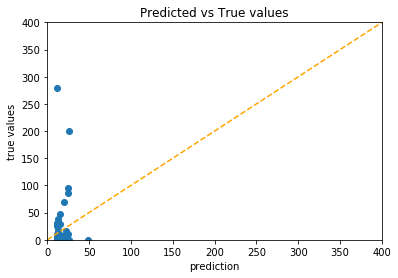

In [17]:
# plot the results
plt.scatter(y_pred, y_test)
plt.plot(np.linspace(0,400,400), np.linspace(0,400,400), c = 'orange', linestyle='--')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.xlim(0,400)
plt.ylim(0,400)
plt.title('Predicted vs True values')

## Conclusions

## References and Further Reading
1. [SmoteR paper](https://core.ac.uk/download/pdf/29202178.pdf)
2. [Utility-based regression paper](https://www.researchgate.net/publication/220699419_Utility-Based_Regression)
3. [SMOGN paper](http://proceedings.mlr.press/v74/branco17a/branco17a.pdf): an enchancement of SmoteR
4. [SMOGN implementation](https://pypi.org/project/smogn/) in Python